In [3]:
import pandas as pd

# Specify the full path to the file
train_data = pd.read_csv('/Users/sharathkumarhodigere/Downloads/covid-train.csv')
test_data = pd.read_csv('/Users/sharathkumarhodigere/Downloads/covid-test.csv')

# Display the first few rows of the training data
print("Training Data Overview:")
print(train_data.head())

# Display the first few rows of the test data
print("\nTest Data Overview:")
print(test_data.head())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Training Data Overview:
   id   AL   AK   AZ   AR   CA   CO   CT   FL   GA  ...  restaurant.2  \
0   0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.812411   
1   1  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.682974   
2   2  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     23.593983   
3   3  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     22.576992   
4   4  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     22.091433   

   spent_time.2  large_event.2  public_transit.2  anxious.2  depressed.2  \
0     43.430423      16.151527          1.602635  15.409449    12.088688   
1     43.196313      16.123386          1.641863  15.230063    11.809047   
2     43.362200      16.159971          1.677523  15.717207    12.355918   
3     42.954574      15.544373          1.578030  15.295650    12.218123   
4     43.290957      15.214655          1.641667  14.778802    12.417256   

   felt_isolated.2  worried_become_ill.2  worried_finances.2  \
0        16.7020

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Prepare the data
X = train_data.drop(columns=['tested_positive.2', 'id']).values  # Define the input features
y = train_data['tested_positive.2'].values  # Define the target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Print the shape of the tensors to verify data preparation
print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)
print("y_val_tensor shape:", y_val_tensor.shape)


X_train_tensor shape: torch.Size([2160, 93])
y_train_tensor shape: torch.Size([2160, 1])
X_val_tensor shape: torch.Size([540, 93])
y_val_tensor shape: torch.Size([540, 1])


In [5]:
import torch.nn as nn
import torch.optim as optim

# Define the Neural Network
class CovidPredictor(nn.Module):
    def __init__(self, input_dim):
        super(CovidPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer with 128 neurons
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
        self.fc3 = nn.Linear(64, 32)  # Third hidden layer with 32 neurons
        self.fc4 = nn.Linear(32, 1)  # Output layer (for regression)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = torch.relu(self.fc3(x))  # Apply ReLU activation
        x = self.fc4(x)  # No activation for the output (regression problem)
        return x

# Instantiate the model
input_dim = X_train.shape[1]  # Number of input features
model = CovidPredictor(input_dim)
# Print the model architecture
print(model)


CovidPredictor(
  (fc1): Linear(in_features=93, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [6]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001


In [7]:
# Training the model
epochs = 100  # Number of epochs
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients
    outputs = model(X_train_tensor)  # Forward pass: compute predictions
    train_loss = criterion(outputs, y_train_tensor)  # Compute training loss
    train_loss.backward()  # Backward pass: compute gradients
    optimizer.step()  # Update model parameters
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        val_outputs = model(X_val_tensor)  # Compute validation predictions
        val_loss = criterion(val_outputs, y_val_tensor)  # Compute validation loss
    
    # Store the losses for monitoring
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [10/100], Train Loss: 316.9535, Val Loss: 312.7520
Epoch [20/100], Train Loss: 266.5537, Val Loss: 257.0807
Epoch [30/100], Train Loss: 138.9066, Val Loss: 122.5725
Epoch [40/100], Train Loss: 23.4977, Val Loss: 24.6572
Epoch [50/100], Train Loss: 18.9786, Val Loss: 15.2517
Epoch [60/100], Train Loss: 13.8641, Val Loss: 14.5184
Epoch [70/100], Train Loss: 7.9486, Val Loss: 8.4923
Epoch [80/100], Train Loss: 6.8044, Val Loss: 7.1866
Epoch [90/100], Train Loss: 5.6673, Val Loss: 6.2976
Epoch [100/100], Train Loss: 4.8402, Val Loss: 5.4118


Matplotlib is building the font cache; this may take a moment.


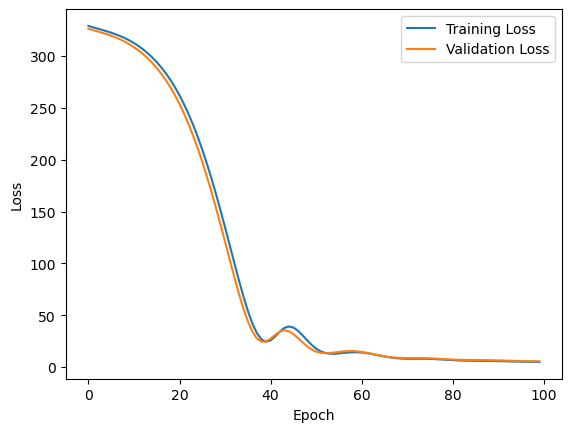

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# Preprocess the test data
X_test = test_data.drop(columns=['id']).values  # Exclude the 'id' column
X_test = scaler.transform(X_test)  # Apply the same scaling as the training data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Make predictions on the test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor)

# Convert predictions to a readable format
predicted_values = predictions.numpy().flatten()
print(predicted_values)


[18.778585   5.3101683  6.578351   5.913372   5.6555805 25.69915
 20.837826   2.1857915 12.5090475  9.65899   20.96539   22.29504
 23.61758    7.255824  18.458721  14.657165  26.886145   6.227803
 22.468624   5.6516485  7.243701  18.607185  20.76589   12.402487
 11.161935  21.125385  21.77396   22.904081   5.9167852 22.069128
  9.477538   9.63516   22.259748   5.131526  13.976646  23.641298
 13.8642     9.597631  11.737808   5.7882442 15.185469   5.884692
  9.885449   9.290708   9.609727  10.674824  15.317177   5.1263475
  6.9230356 11.061944  10.885779  10.497425  10.587147   8.029776
 11.779611  29.250423   6.1968374 10.657243  29.854485  11.13769
 15.869679  14.176439  14.246102  18.66579   16.219732   5.1011276
  6.921378  20.929045  25.222736  18.488497  24.018698  16.912605
 13.311933  27.80382   10.617348   7.9267073 16.758781  12.7705
  4.849025  11.125721  21.07213    9.143212   9.774055  12.288275
  6.653077   8.894941  23.676199   9.523355   5.2377605 19.882772
 19.059668  3

In [11]:
# Assuming you already have y_val_tensor as the true values for the validation set
y_val_pred = model(X_val_tensor)  # Get the predictions for validation set
y_val_pred = y_val_pred.detach().numpy().flatten()  # Convert predictions to numpy array

# Calculate Mean Squared Error
mse = mean_squared_error(y_val_tensor.numpy().flatten(), y_val_pred)
print("Validation Mean Squared Error:", mse)


Validation Mean Squared Error: 5.4118166
